# Chest X-Ray Images (Pneumonia)

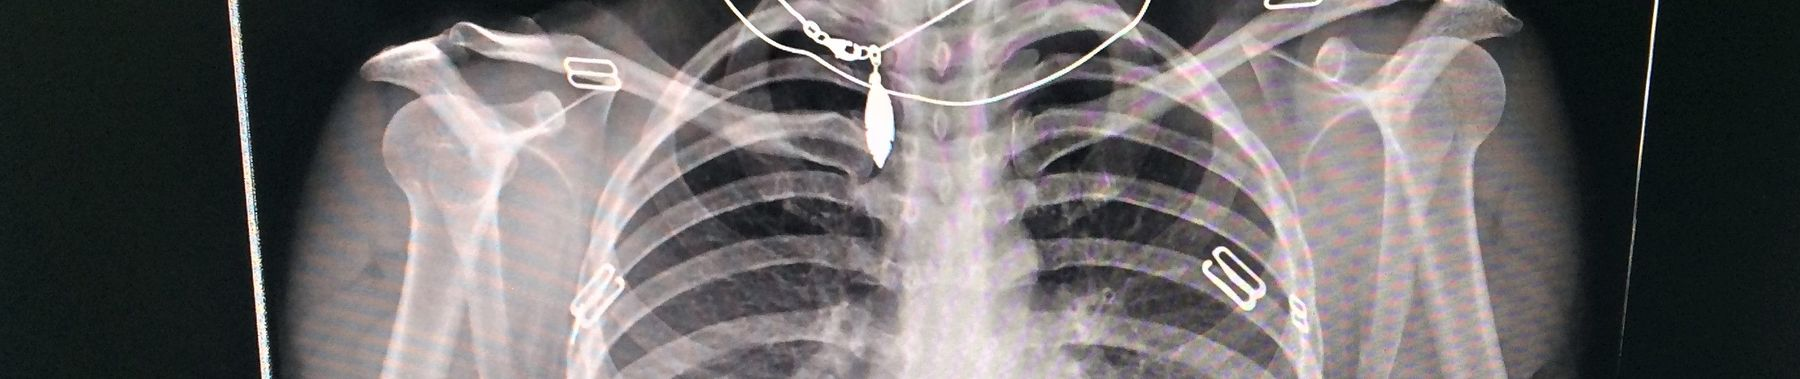

Kacey Clougher, Rachel Goldstein, Irwin Lam, and Kendall McNeil

DESCRIPTION:

OBJECTIVE:

DEFINING KEY TERMS:

METHODOLOGY:

# 1. Loading In and Exploring the Data

In [1]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
import numpy as np
import os
import tensorflow as tf

First, we need to create our directory paths to input into our image generators.
Then we need to create the datasets.

In [5]:
cd ..

C:\Users\Jackson\Documents\flatiron\Pneumonia X Rays


In [6]:
# Directory paths for train, test, and val
train_path = r'data\archive (3)\chest_xray\train'
test_path = r'data\archive (3)\chest_xray\test'
val_path = r'data\archive (3)\chest_xray\val'

# Import the train directory data, which includes both normal and pneumonia (5216 total) and reshape them
train_generator = ImageDataGenerator(rescale=1.0/255).flow_from_directory(
        train_path, 
        target_size=(64, 64), batch_size=5216)

# Import the test directory data, which includes both normal and pneumonia (624 total) and reshape them
test_generator = ImageDataGenerator(rescale=1.0/255).flow_from_directory(
        test_path, 
        target_size=(64, 64), batch_size=624)

# Import the val directory data, which includes both normal and pneumonia (8 each - 16 total) and reshape them
val_generator = ImageDataGenerator(rescale=1.0/255).flow_from_directory(
        val_path, 
        target_size=(64, 64), batch_size=16)

# Create the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


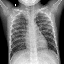

In [10]:
array_to_img(train_images[0])

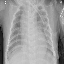

In [11]:
array_to_img(train_images[4])

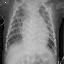

In [12]:
array_to_img(test_images[0])

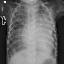

In [13]:
array_to_img(test_images[4])

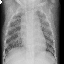

In [14]:
array_to_img(val_images[0])

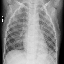

In [15]:
array_to_img(val_images[4])

In [35]:
print(f"train images: {train_images.shape}")
print(f"train labels: {train_labels.shape}")
print(f"test images: {test_images.shape}")
print(f"test labels: {test_labels.shape}")
print(f"val images: {val_images.shape}")
print(f"val labels: {val_labels.shape}")

train images: (5216, 64, 64, 3)
train labels: (5216, 2)
test images: (624, 64, 64, 3)
test labels: (624, 2)
val images: (16, 64, 64, 3)
val labels: (16, 2)


In [18]:
#train_n = train_images.shape[0]
#test_n = test_images.shape[0]
#val_n = val_images.shape[0]

In [19]:
# Reshape the train images 
#train_img_unrow = train_images.reshape(train_n, -1).T

In [20]:
#train_img_unrow

In [21]:
# Reshape the test images 
#test_img_unrow = test_images.reshape(test_n, -1).T

In [22]:
#test_img_unrow

In [23]:
# Reshape the val images 
#val_img_unrow = val_images.reshape(val_n, -1).T

In [24]:
#val_img_unrow

Let's check on our target variable.

In [25]:
train_generator.class_indices 

{'NORMAL': 0, 'PNEUMONIA': 1}

Interpretation: 0 represents a normal x-ray with no pneumonia. 1 represents an x-ray of a chest with pneumonia.

In [36]:
train_labels_final = train_labels.T[0]
test_labels_final = test_labels.T[0]
val_labels_final = val_labels.T[0]

print(f"train labels updated shape: {train_labels_final.shape}")
print(f"test labels updated shape: {test_labels_final.shape}")
print(f"val labels updated shape: {val_labels_final.shape}")

train labels updated shape: (5216,)
test labels updated shape: (624,)
val labels updated shape: (16,)


Let's checkout a chest x-ray with pneumonia as a sanity check.

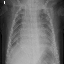

In [37]:
array_to_img(train_images[240])

Let's checkout a chest x-ray without pneumonia as a sanity check.

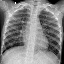

In [39]:
array_to_img(train_images[1500])

# 2. Standardize the Data

In [ ]:
#from keras.datasets import mnist
#(train_images, train_labels_final), (test_images, test_labels_final) = mnist.load_data()
# check out pixel values
#print('Train', train_images.min(), train_images.max(), train_images.mean(), train_images.std())
#print('Test', test_images.min(), test_images.max(), test_images.mean(), test_images.std())

Each image takes a value between 0 and 255 so to standardize the data, we will divide by 255. 

In [ ]:
#train_img_unrow

In [ ]:
#train_images = train_img_unrow/255
#test_images = test_img_unrow/255
#val_images = test_img_unrow/255

# 3. Explore Models

In [41]:
from keras import models
from keras import layers
from keras import optimizers

In [47]:
#make sure to change these to 0 or 1
train_labels_final

array([1., 0., 1., ..., 0., 0., 0.], dtype=float32)

In [48]:
first_model = models.Sequential()
first_model.add(layers.Dense(10, activation='relu', input_shape=(64, 64, 3)))
first_model.add(layers.Flatten())
first_model.add(layers.Dense(2, activation='softmax'))

In [55]:
first_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [56]:
first_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64, 64, 10)        40        
                                                                 
 flatten (Flatten)           (None, 40960)             0         
                                                                 
 dense_1 (Dense)             (None, 2)                 81922     
                                                                 
Total params: 81962 (320.16 KB)
Trainable params: 81962 (320.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [57]:
first_model.fit(train_images,
                    train_labels,
                    epochs=10,
                    batch_size=64)

Epoch 1/10
82/82 [==============================] - 4s 30ms/step - loss: 0.0055 - accuracy: 0.9987
Epoch 2/10
82/82 [==============================] - 2s 29ms/step - loss: 9.5840e-04 - accuracy: 1.0000
Epoch 3/10
82/82 [==============================] - 2s 29ms/step - loss: 0.0013 - accuracy: 1.0000
Epoch 4/10
82/82 [==============================] - 2s 27ms/step - loss: 0.0036 - accuracy: 0.9992
Epoch 5/10
82/82 [==============================] - 2s 28ms/step - loss: 0.0208 - accuracy: 0.9925
Epoch 6/10
82/82 [==============================] - 2s 29ms/step - loss: 0.0135 - accuracy: 0.9942
Epoch 7/10
82/82 [==============================] - 2s 29ms/step - loss: 0.0021 - accuracy: 0.9996
Epoch 8/10
82/82 [==============================] - 2s 28ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 9/10
82/82 [==============================] - 2s 29ms/step - loss: 8.8646e-04 - accuracy: 1.0000
Epoch 10/10
82/82 [==============================] - 2s 27ms/step - loss: 8.6332e-04 - accuracy: 1.00

In [67]:
second_model = models.Sequential()
second_model.add(layers.Conv2D(filters=32,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(64, 64, 3)))

second_model.add(layers.Conv2D(64, (3, 3), activation='relu'))

second_model.add(layers.Flatten())
second_model.add(layers.Dense(1, activation='sigmoid')) 

In [68]:
second_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [69]:
second_model.fit(train_images,train_labels_final,epochs=10,batch_size=64)

Epoch 1/10
82/82 [==============================] - 36s 411ms/step - loss: 0.3551 - accuracy: 0.8485
Epoch 2/10
82/82 [==============================] - 34s 416ms/step - loss: 0.1075 - accuracy: 0.9576
Epoch 3/10
82/82 [==============================] - 34s 415ms/step - loss: 0.0747 - accuracy: 0.9718
Epoch 4/10
82/82 [==============================] - 34s 412ms/step - loss: 0.0599 - accuracy: 0.9781
Epoch 5/10
82/82 [==============================] - 33s 400ms/step - loss: 0.0585 - accuracy: 0.9787
Epoch 6/10
82/82 [==============================] - 33s 402ms/step - loss: 0.0336 - accuracy: 0.9893
Epoch 7/10
82/82 [==============================] - 33s 400ms/step - loss: 0.0271 - accuracy: 0.9900
Epoch 8/10
82/82 [==============================] - 33s 400ms/step - loss: 0.0113 - accuracy: 0.9981
Epoch 9/10
82/82 [==============================] - 33s 408ms/step - loss: 0.0106 - accuracy: 0.9981
Epoch 10/10
82/82 [==============================] - 33s 406ms/step - loss: 0.0058 - accura

In [70]:
third_model = models.Sequential()
third_model.add(layers.Conv2D(filters=32,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(64, 64, 3)))

#add a hidden layer
third_model.add(layers.MaxPooling2D(pool_size=(2, 2)))
third_model.add(layers.Conv2D(64, (3, 3), activation='relu'))

third_model.add(layers.Flatten())
third_model.add(layers.Dense(1, activation='sigmoid')) 

In [71]:
third_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [72]:
third_model.fit(train_images,train_labels_final,epochs=10,batch_size=64)

Epoch 1/10
82/82 [==============================] - 16s 173ms/step - loss: 0.3158 - accuracy: 0.8620
Epoch 2/10
82/82 [==============================] - 14s 172ms/step - loss: 0.1187 - accuracy: 0.9549
Epoch 3/10
82/82 [==============================] - 14s 173ms/step - loss: 0.0970 - accuracy: 0.9615
Epoch 4/10
82/82 [==============================] - 14s 171ms/step - loss: 0.0880 - accuracy: 0.9661
Epoch 5/10
82/82 [==============================] - 14s 169ms/step - loss: 0.0686 - accuracy: 0.9739
Epoch 6/10
82/82 [==============================] - 14s 170ms/step - loss: 0.0633 - accuracy: 0.9776
Epoch 7/10
82/82 [==============================] - 14s 172ms/step - loss: 0.0533 - accuracy: 0.9804
Epoch 8/10
82/82 [==============================] - 14s 174ms/step - loss: 0.0440 - accuracy: 0.9839
Epoch 9/10
82/82 [==============================] - 14s 170ms/step - loss: 0.0384 - accuracy: 0.9864
Epoch 10/10
82/82 [==============================] - 14s 174ms/step - loss: 0.0387 - accura

In [82]:
from keras import regularizers
fourth_model = models.Sequential()

fourth_model.add(layers.Conv2D(filters=32, kernel_size=(3, 3),
                               activation='relu', kernel_regularizer=regularizers.l2(.005), 
                               input_shape=(64, 64, 3)))

fourth_model.add(layers.Flatten())
fourth_model.add(layers.Dense(1, activation='sigmoid'))

In [83]:
fourth_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [88]:
fourth_model_results = fourth_model.fit(train_images,train_labels_final,epochs=10,batch_size=64)

Epoch 1/10
82/82 [==============================] - 7s 82ms/step - loss: 0.0425 - accuracy: 0.9962
Epoch 2/10
82/82 [==============================] - 7s 84ms/step - loss: 0.0398 - accuracy: 0.9988
Epoch 3/10
82/82 [==============================] - 7s 82ms/step - loss: 0.0337 - accuracy: 0.9990
Epoch 4/10
82/82 [==============================] - 7s 82ms/step - loss: 0.0318 - accuracy: 0.9998
Epoch 5/10
82/82 [==============================] - 7s 84ms/step - loss: 0.0304 - accuracy: 1.0000
Epoch 6/10
82/82 [==============================] - 7s 87ms/step - loss: 0.0295 - accuracy: 0.9996
Epoch 7/10
82/82 [==============================] - 7s 81ms/step - loss: 0.0271 - accuracy: 0.9998
Epoch 8/10
82/82 [==============================] - 7s 85ms/step - loss: 0.0289 - accuracy: 0.9987
Epoch 9/10
82/82 [==============================] - 7s 84ms/step - loss: 0.0239 - accuracy: 1.0000
Epoch 10/10
82/82 [==============================] - 7s 87ms/step - loss: 0.0233 - accuracy: 1.0000


In [86]:
train_loss, train_acc = fourth_model.evaluate(train_images, train_labels_final)

163/163 [==============================] - 6s 18ms/step - loss: 0.0379 - accuracy: 0.9990


In [87]:
test_loss, test_acc = fourth_model.evaluate(test_images, test_labels_final)

20/20 [==============================] - 1s 18ms/step - loss: 1.0495 - accuracy: 0.7404


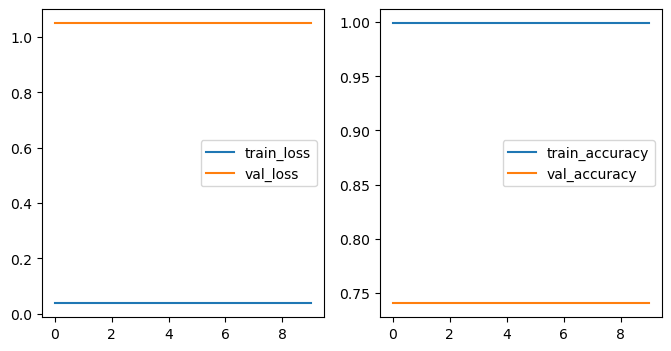

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
sns.lineplot(x=fourth_model_results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=fourth_model_results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=fourth_model_results.epoch, y=test_loss, ax=ax1, label='val_loss')
sns.lineplot(x=fourth_model_results.epoch, y=test_acc, ax=ax2, label='val_accuracy');

L2 regularization did not seem to help a whole lot. Our model is still very overfit. Let's try the dropout method.

In [98]:
#DROPOUT METHOD TO MITIGATE THE IMPACTS OF OVERFITTING
# ⏰ This cell may take about a minute to run
fifth_model = models.Sequential()

# Implement dropout to the input layer
# NOTE: This is where you define the number of units in the input layer
fifth_model.add(layers.Dropout(.3, input_shape=(64,64,3)))

# Add the first hidden layer
fifth_model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'))

# Implement dropout to the first hidden layer 
fifth_model.add(layers.Dropout(.3))

# Add the second hidden layer
fifth_model.add(layers.MaxPooling2D(pool_size=(2,2)))
fifth_model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Implement dropout to the second hidden layer 
fifth_model.add(layers.Dropout(.3))

# Add the output layer
fifth_model.add(layers.Flatten())
fifth_model.add(layers.Dense(1, activation='sigmoid'))

In [99]:
fifth_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [100]:
fifth_model_results = fifth_model.fit(train_images,train_labels_final,epochs=10,batch_size=64)

Epoch 1/10
82/82 [==============================] - 31s 337ms/step - loss: 0.4612 - accuracy: 0.7966
Epoch 2/10
82/82 [==============================] - 26s 321ms/step - loss: 0.1654 - accuracy: 0.9344
Epoch 3/10
82/82 [==============================] - 27s 325ms/step - loss: 0.1332 - accuracy: 0.9471
Epoch 4/10
82/82 [==============================] - 28s 340ms/step - loss: 0.1489 - accuracy: 0.9431
Epoch 5/10
82/82 [==============================] - 27s 333ms/step - loss: 0.1075 - accuracy: 0.9622
Epoch 6/10
82/82 [==============================] - 27s 323ms/step - loss: 0.1058 - accuracy: 0.9569
Epoch 7/10
82/82 [==============================] - 27s 331ms/step - loss: 0.1106 - accuracy: 0.9595
Epoch 8/10
82/82 [==============================] - 27s 333ms/step - loss: 0.0973 - accuracy: 0.9638
Epoch 9/10
82/82 [==============================] - 27s 326ms/step - loss: 0.0832 - accuracy: 0.9674
Epoch 10/10
82/82 [==============================] - 27s 325ms/step - loss: 0.0819 - accura

In [101]:
train_loss, train_acc = fifth_model.evaluate(train_images, train_labels_final)

163/163 [==============================] - 6s 33ms/step - loss: 0.1489 - accuracy: 0.9643


In [102]:
test_loss, test_acc = fifth_model.evaluate(test_images, test_labels_final)

20/20 [==============================] - 1s 32ms/step - loss: 0.5612 - accuracy: 0.7019


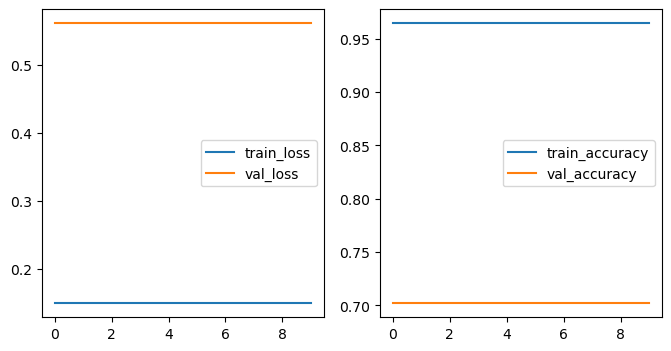

In [103]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
sns.lineplot(x=fifth_model_results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=fifth_model_results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=fifth_model_results.epoch, y=test_loss, ax=ax1, label='val_loss')
sns.lineplot(x=fifth_model_results.epoch, y=test_acc, ax=ax2, label='val_accuracy');